# 05: 11-Gene Signature Analysis

**CSC 427 - Bioinformatics Final Project**

This notebook implements Phase 5 of the PRECISE pipeline reproduction:

1. **Verify signature genes** are present in our dataset
2. **Visualize expression** of signature genes across responders vs. non-responders
3. **Rank signature genes** by feature importance from our models
4. **Train 11-gene-only model** and evaluate AUC
5. **Compare all model AUCs** in a summary table/plot

## The 11-Gene Signature from PRECISE Paper

The paper identifies an 11-gene signature predictive of ICI response:

| Gene | Description |
|------|-------------|
| GAPDH | Glyceraldehyde-3-phosphate dehydrogenase |
| CD38 | Cyclic ADP ribose hydrolase |
| CCR7 | C-C chemokine receptor type 7 |
| HLA-DRB5 | MHC class II antigen |
| STAT1 | Signal transducer and activator of transcription 1 |
| GZMH | Granzyme H |
| LGALS1 | Galectin-1 |
| IFI6 | Interferon alpha-inducible protein 6 |
| EPSTI1 | Epithelial stromal interaction 1 |
| HLA-G | MHC class I antigen |
| GBP5 | Guanylate binding protein 5 |


In [1]:
# Standard library
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Data science
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add src to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Our modules
from src import (
    load_preprocessed_data,
    DEFAULT_OUTPUT_PATH,
    PRECISE_11_GENE_SIGNATURE,
    leave_one_patient_out_cv,
    evaluate_signature_genes,
    evaluate_model_results,
    plot_roc_curve,
)
from src.signature_analysis import (
    check_signature_genes_presence,
    get_signature_gene_ranks,
    plot_signature_gene_expression,
    plot_signature_importance_comparison,
    plot_model_comparison,
    plot_combined_roc_curves,
    run_signature_analysis,
    generate_final_comparison_table,
)

# Configure plots
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("Imports successful!")
print(f"Project root: {project_root}")


Imports successful!
Project root: /Users/tarekalakkadp/Desktop/uvic/fourth-year/fall/csc427/final-project/scRNA-immunotherapy-response-ml


## 1. Load Data and Previous Results


In [2]:
# Load preprocessed AnnData
adata_path = project_root / DEFAULT_OUTPUT_PATH
adata = load_preprocessed_data(adata_path)

print(f"\nLoaded dataset:")
print(f"  Cells: {adata.n_obs:,}")
print(f"  Genes: {adata.n_vars:,}")
print(f"  Patients: {adata.obs['patient_id'].nunique()}")


Loaded preprocessed data from: /Users/tarekalakkadp/Desktop/uvic/fourth-year/fall/csc427/final-project/scRNA-immunotherapy-response-ml/data/processed/melanoma_adata.h5ad
Shape: 16,290 cells x 12,785 genes

Loaded dataset:
  Cells: 16,290
  Genes: 12,785
  Patients: 48


In [3]:
# Load feature importances from Phase 4
importance_path = project_root / "results" / "tables" / "feature_importances.csv"

if importance_path.exists():
    importance_df = pd.read_csv(importance_path)
    print(f"Loaded feature importances: {len(importance_df)} genes")
    print(f"\nTop 10 genes by importance:")
    display(importance_df.head(10)[['gene', 'importance', 'rank']])
else:
    print("Feature importances not found. Will compute during analysis.")
    importance_df = None


Loaded feature importances: 12785 genes

Top 10 genes by importance:


,gene,importance,rank
0,GAPDH,456.800690,1
1,IFI6,254.579228,2
2,ANXA5,223.527089,3
3,STAT1,158.856277,4
4,PSME2,149.765219,5
5,LGALS1,126.154250,6
6,CCL4L1,121.605237,7
7,GBP5,118.262707,8
8,CD38,110.003907,9
9,EPSTI1,109.191994,10


## 2. Task 5.1: Check Presence of 11 Signature Genes


In [4]:
# The 11-gene signature from the PRECISE paper
print("11-Gene Signature from PRECISE Paper:")
print("="*50)
for i, gene in enumerate(PRECISE_11_GENE_SIGNATURE, 1):
    print(f"{i:2d}. {gene}")


11-Gene Signature from PRECISE Paper:
 1. GAPDH
 2. CD38
 3. CCR7
 4. HLA-DRB5
 5. STAT1
 6. GZMH
 7. LGALS1
 8. IFI6
 9. EPSTI1
10. HLA-G
11. GBP5


In [5]:
# Check which genes are present in our dataset
presence_info = check_signature_genes_presence(adata, verbose=True)


SIGNATURE GENE PRESENCE CHECK

Signature genes found: 11/11
All genes present: True

Genes FOUND (11):
  ✓ GAPDH
  ✓ CD38
  ✓ CCR7
  ✓ HLA-DRB5
  ✓ STAT1
  ✓ GZMH
  ✓ LGALS1
  ✓ IFI6
  ✓ EPSTI1
  ✓ HLA-G
  ✓ GBP5


In [6]:
# Display presence DataFrame
display(presence_info['presence_df'])


,gene,present,status
0,GAPDH,True,Found
1,CD38,True,Found
2,CCR7,True,Found
3,HLA-DRB5,True,Found
4,STAT1,True,Found
5,GZMH,True,Found
6,LGALS1,True,Found
7,IFI6,True,Found
8,EPSTI1,True,Found
9,HLA-G,True,Found


### Visualize Signature Gene Expression


Signature expression plot saved to: /Users/tarekalakkadp/Desktop/uvic/fourth-year/fall/csc427/final-project/scRNA-immunotherapy-response-ml/results/figures/signature_genes_expression.png


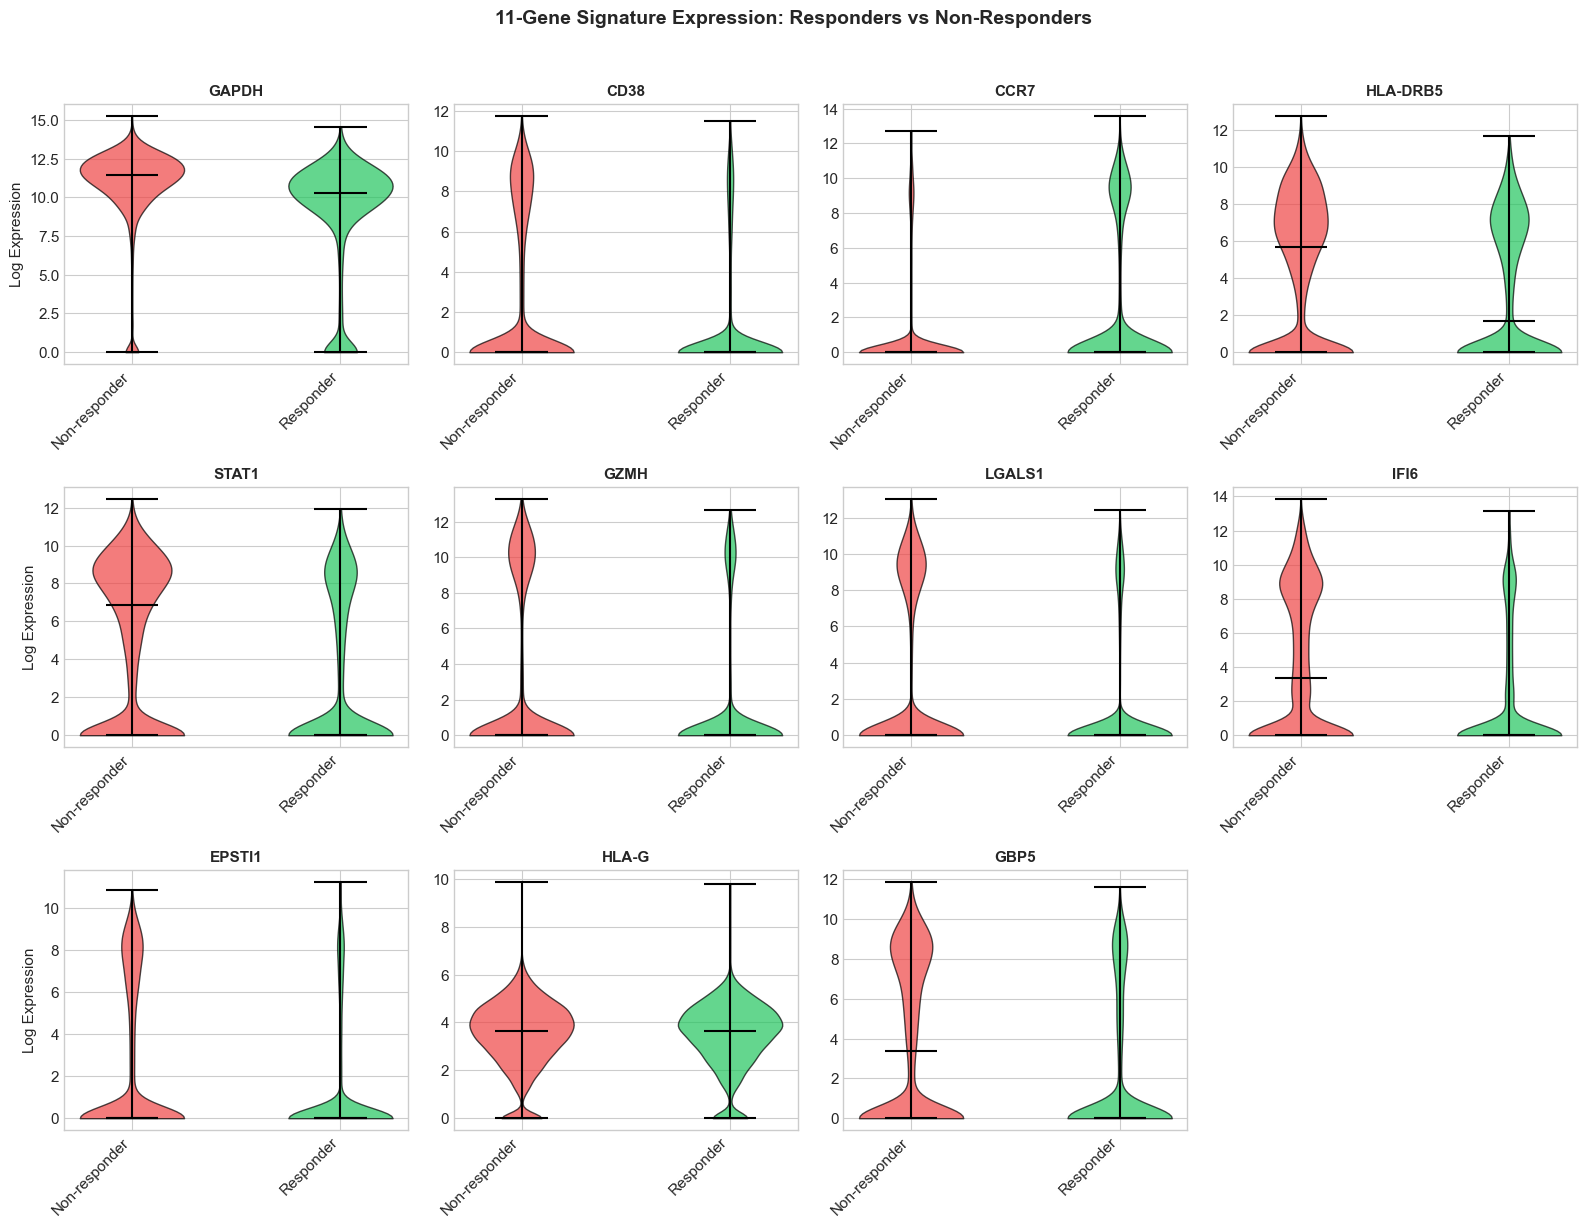

In [9]:
# Force reload module to ensure latest code is used
import importlib
import src.signature_analysis
importlib.reload(src.signature_analysis)
from src.signature_analysis import plot_signature_gene_expression

# Create violin plots for signature genes
fig = plot_signature_gene_expression(
    adata,
    signature_genes=PRECISE_11_GENE_SIGNATURE,
    save_path=project_root / "results" / "figures" / "signature_genes_expression.png",
    figsize=(16, 12)
)
plt.show()


## 3. Task 5.2: Rank Signature Genes by Importance


In [10]:
# Get ranks of signature genes in our feature importance analysis
if importance_df is not None:
    ranks_df = get_signature_gene_ranks(importance_df, verbose=True)
    
    # Save ranks table
    ranks_path = project_root / "results" / "tables" / "signature_gene_ranks.csv"
    ranks_df.to_csv(ranks_path, index=False)
    print(f"\nSaved to: {ranks_path}")
else:
    print("Cannot compute ranks without feature importances.")
    ranks_df = None


SIGNATURE GENE RANKINGS

Gene             Rank   Importance   Top 50   Top 100
--------------------------------------------------
GAPDH               1       456.80      Yes       Yes
IFI6                2       254.58      Yes       Yes
STAT1               4       158.86      Yes       Yes
LGALS1              6       126.15      Yes       Yes
GBP5                8       118.26      Yes       Yes
CD38                9       110.00      Yes       Yes
EPSTI1             10       109.19      Yes       Yes
CCR7               13        90.35      Yes       Yes
GZMH               37        51.21      Yes       Yes
HLA-DRB5           45        46.49      Yes       Yes
HLA-G             142        23.05       No        No

SUMMARY
Signature genes in top 50:  10/11
Signature genes in top 100: 10/11
Average rank: 25.2
Median rank:  9.0

Saved to: /Users/tarekalakkadp/Desktop/uvic/fourth-year/fall/csc427/final-project/scRNA-immunotherapy-response-ml/results/tables/signature_gene_ranks.csv


In [11]:
# Display ranks DataFrame
if ranks_df is not None:
    display(ranks_df[['gene', 'importance', 'rank', 'in_top_50', 'in_top_100']])


,gene,importance,rank,in_top_50,in_top_100
0,GAPDH,456.800690,1,True,True
1,IFI6,254.579228,2,True,True
2,STAT1,158.856277,4,True,True
3,LGALS1,126.154250,6,True,True
4,GBP5,118.262707,8,True,True
5,CD38,110.003907,9,True,True
6,EPSTI1,109.191994,10,True,True
7,CCR7,90.346676,13,True,True
8,GZMH,51.207594,37,True,True
9,HLA-DRB5,46.490230,45,True,True


Importance comparison plot saved to: /Users/tarekalakkadp/Desktop/uvic/fourth-year/fall/csc427/final-project/scRNA-immunotherapy-response-ml/results/figures/signature_importance_comparison.png


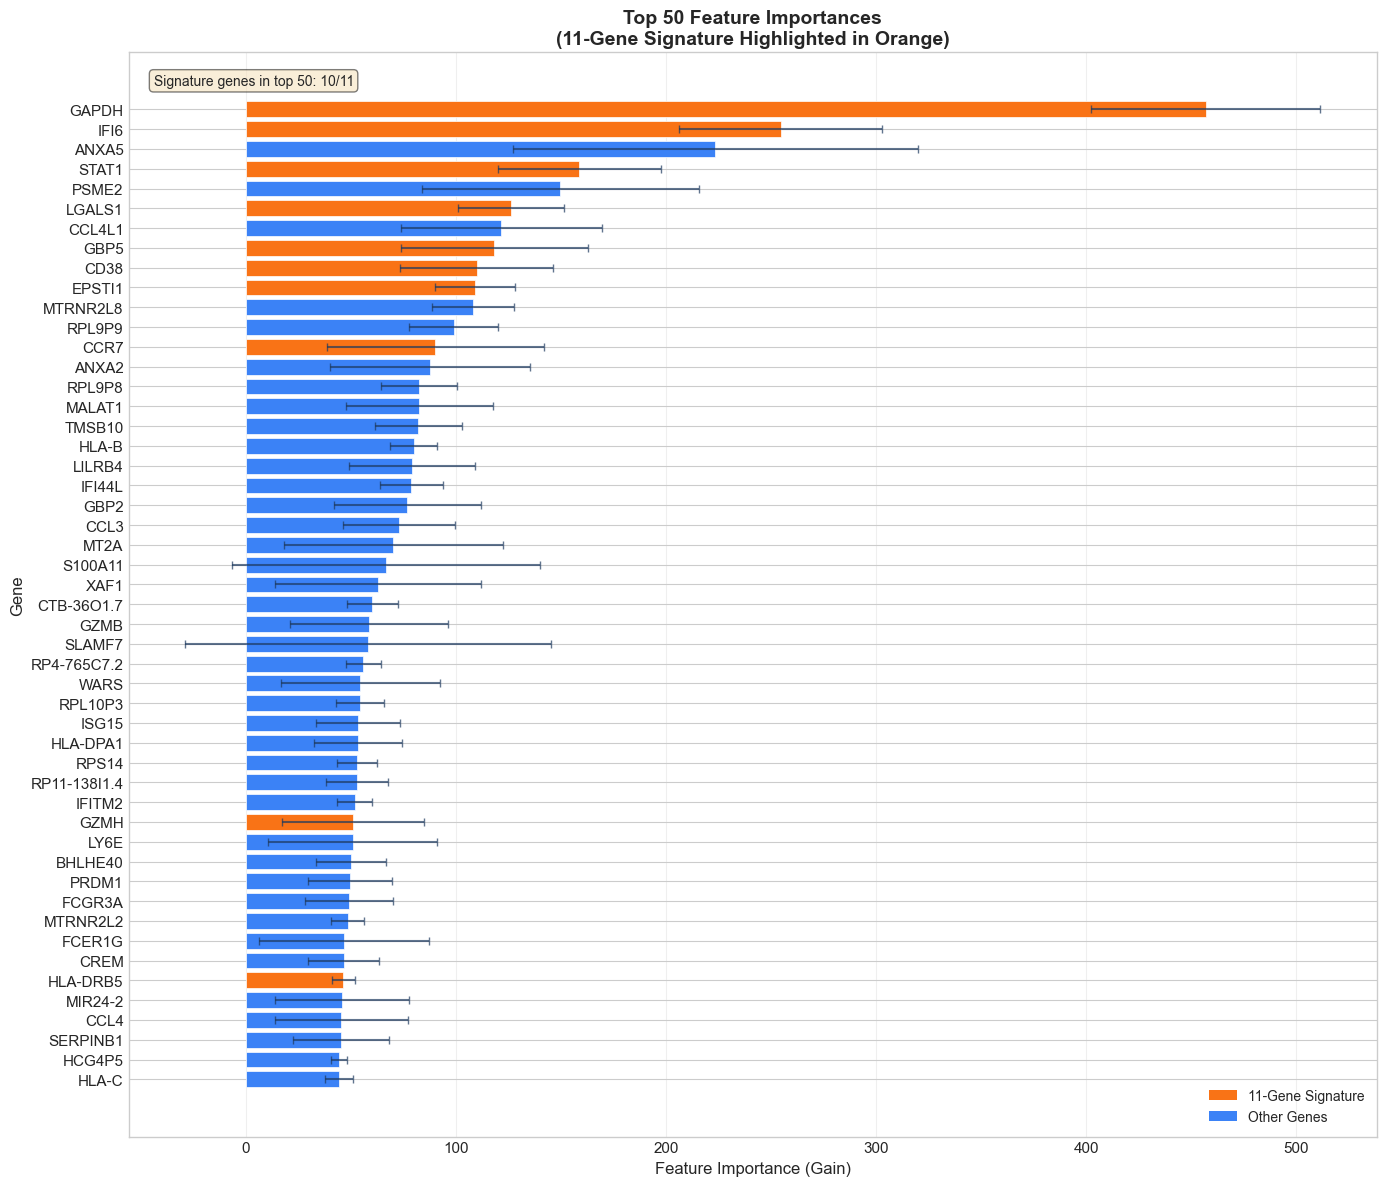

In [12]:
# Create importance comparison plot
if importance_df is not None:
    fig = plot_signature_importance_comparison(
        importance_df,
        signature_genes=PRECISE_11_GENE_SIGNATURE,
        top_n=50,
        save_path=project_root / "results" / "figures" / "signature_importance_comparison.png",
        figsize=(14, 12)
    )
    plt.show()


### Analysis: Signature Gene Overlap with Our Top Features


In [13]:
if ranks_df is not None:
    # Summary statistics
    n_in_top_50 = ranks_df['in_top_50'].sum()
    n_in_top_100 = ranks_df['in_top_100'].sum()
    avg_rank = ranks_df['rank'].mean()
    median_rank = ranks_df['rank'].median()
    
    print("Signature Gene Overlap Analysis")
    print("="*50)
    print(f"Signature genes in our top 50:  {n_in_top_50}/11 ({n_in_top_50/11:.1%})")
    print(f"Signature genes in our top 100: {n_in_top_100}/11 ({n_in_top_100/11:.1%})")
    print(f"Average rank of signature genes: {avg_rank:.1f}")
    print(f"Median rank of signature genes: {median_rank:.1f}")
    
    print(f"\nTotal genes in our analysis: {len(importance_df)}")
    print(f"Signature genes rank percentile: {(1 - avg_rank/len(importance_df))*100:.1f}%")


Signature Gene Overlap Analysis
Signature genes in our top 50:  10/11 (90.9%)
Signature genes in our top 100: 10/11 (90.9%)
Average rank of signature genes: 25.2
Median rank of signature genes: 9.0

Total genes in our analysis: 12785
Signature genes rank percentile: 99.8%


## 4. Task 5.3: Train 11-Gene-Only Model


In [14]:
# Train XGBoost using ONLY the 11 signature genes
print("Training 11-Gene Signature Model (LOO-CV)")
print("="*60)

signature_results = evaluate_signature_genes(
    adata,
    PRECISE_11_GENE_SIGNATURE,
    verbose=True
)

signature_auc = signature_results['auc']
print(f"\n*** 11-Gene Signature AUC: {signature_auc:.4f} ***")


Training 11-Gene Signature Model (LOO-CV)

Signature genes found: 11/11
Running LOO-CV with 11 signature genes...
LEAVE-ONE-PATIENT-OUT CROSS-VALIDATION

Dataset: 16,290 cells x 11 genes
Patients: 48
XGBoost params: defaults

Running LOO-CV...
  Completed fold 10/48
  Completed fold 20/48
  Completed fold 30/48
  Completed fold 40/48

  Completed all 48 folds in 7.2 seconds

RESULTS

Patient-level ROC AUC: 0.909
Score range: [0.119, 0.601]
Label distribution: 17 responders, 31 non-responders

*** 11-Gene Signature AUC: 0.9089 ***


ROC curve saved to: /Users/tarekalakkadp/Desktop/uvic/fourth-year/fall/csc427/final-project/scRNA-immunotherapy-response-ml/results/figures/signature_roc.png


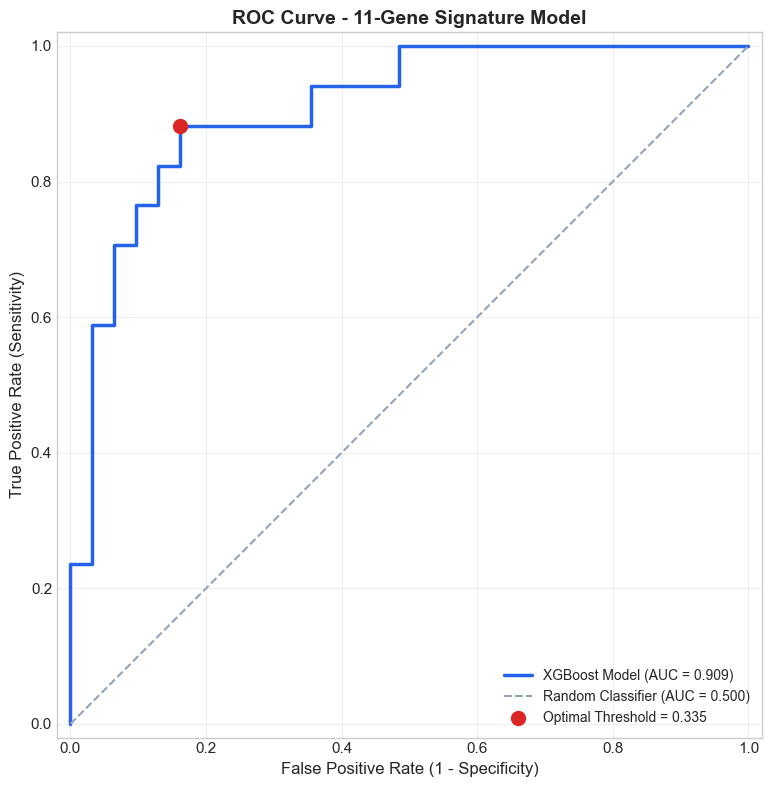

In [15]:
# Plot ROC curve for 11-gene model
patients = list(signature_results['patient_scores'].keys())
y_true_sig = np.array([signature_results['patient_labels'][p] for p in patients])
y_scores_sig = np.array([signature_results['patient_scores'][p] for p in patients])

fig = plot_roc_curve(
    y_true_sig, y_scores_sig,
    title="ROC Curve - 11-Gene Signature Model",
    save_path=project_root / "results" / "figures" / "signature_roc.png"
)
plt.show()


In [16]:
# Load previous results to compare
baseline_results_path = project_root / "results" / "tables" / "baseline_results.csv"
feature_sel_results_path = project_root / "results" / "tables" / "feature_selection_results.csv"

# Initialize AUCs
baseline_auc = None
feature_sel_auc = None

# Load baseline AUC
if baseline_results_path.exists():
    baseline_df = pd.read_csv(baseline_results_path)
    auc_row = baseline_df[baseline_df['Metric'] == 'ROC AUC']
    if len(auc_row) > 0:
        baseline_auc = float(auc_row['Value'].values[0])
        print(f"Baseline AUC: {baseline_auc:.4f}")

# Load feature selection AUC
if feature_sel_results_path.exists():
    fs_df = pd.read_csv(feature_sel_results_path)
    auc_row = fs_df[fs_df['Metric'] == 'ROC AUC']
    if len(auc_row) > 0:
        feature_sel_auc = float(auc_row['Value'].values[0])
        print(f"Feature Selected AUC: {feature_sel_auc:.4f}")

print(f"11-Gene Signature AUC: {signature_auc:.4f}")


Baseline AUC: 0.7704
Feature Selected AUC: 0.7723
11-Gene Signature AUC: 0.9089


In [17]:
# If we don't have saved results, run baseline model
if baseline_auc is None:
    print("Running baseline model to get AUC...")
    baseline_results_full = leave_one_patient_out_cv(adata, verbose=True)
    baseline_auc = baseline_results_full['auc']
    
# If we don't have feature selection results, use baseline as placeholder
if feature_sel_auc is None:
    print("\nNote: Feature selection results not found.")
    print("Please run notebook 04_feature_selection.ipynb first.")
    print("Using baseline AUC as placeholder for comparison.")
    feature_sel_auc = baseline_auc


In [18]:
# Create comparison table
comparison_df = generate_final_comparison_table(
    baseline_auc=baseline_auc,
    feature_selected_auc=feature_sel_auc,
    signature_auc=signature_auc,
    baseline_n_genes=adata.n_vars,
    feature_selected_n_genes=50,  # From Phase 4
    save_path=project_root / "results" / "tables" / "final_comparison.csv"
)

print("\nFinal Model Comparison")
print("="*80)
display(comparison_df)


Final comparison table saved to: /Users/tarekalakkadp/Desktop/uvic/fourth-year/fall/csc427/final-project/scRNA-immunotherapy-response-ml/results/tables/final_comparison.csv

Final Model Comparison


,Model,Our AUC,Paper AUC,N Genes,Notes
0,Baseline XGBoost (All Genes),0.770,0.84,12785,All genes after QC
1,Feature Selected,0.772,0.89,50,Top genes by importance (nested CV)
2,11-Gene Signature,0.909,~0.85*,11,"GAPDH, CD38, CCR7, HLA-DRB5, STAT1, GZMH, LGAL..."


Model comparison plot saved to: /Users/tarekalakkadp/Desktop/uvic/fourth-year/fall/csc427/final-project/scRNA-immunotherapy-response-ml/results/figures/model_auc_comparison.png


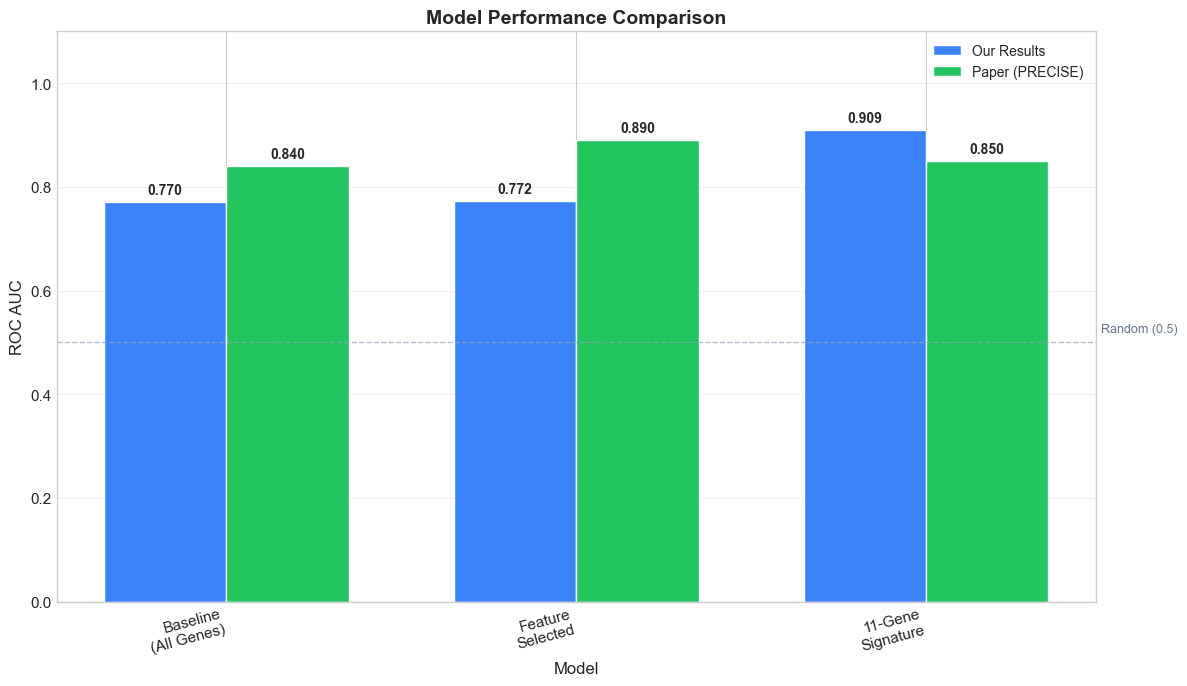

In [19]:
# Create bar plot comparison
model_aucs = {
    "Baseline\n(All Genes)": baseline_auc,
    "Feature\nSelected": feature_sel_auc,
    "11-Gene\nSignature": signature_auc,
}

paper_aucs = {
    "Baseline\n(All Genes)": 0.84,
    "Feature\nSelected": 0.89,
    "11-Gene\nSignature": 0.85,  # Estimated from paper
}

fig = plot_model_comparison(
    model_aucs,
    paper_aucs=paper_aucs,
    save_path=project_root / "results" / "figures" / "model_auc_comparison.png",
    figsize=(12, 7)
)
plt.show()


## 6. Combined ROC Curves


Running baseline model for ROC curve data...
Combined ROC curve saved to: /Users/tarekalakkadp/Desktop/uvic/fourth-year/fall/csc427/final-project/scRNA-immunotherapy-response-ml/results/figures/combined_roc_comparison.png


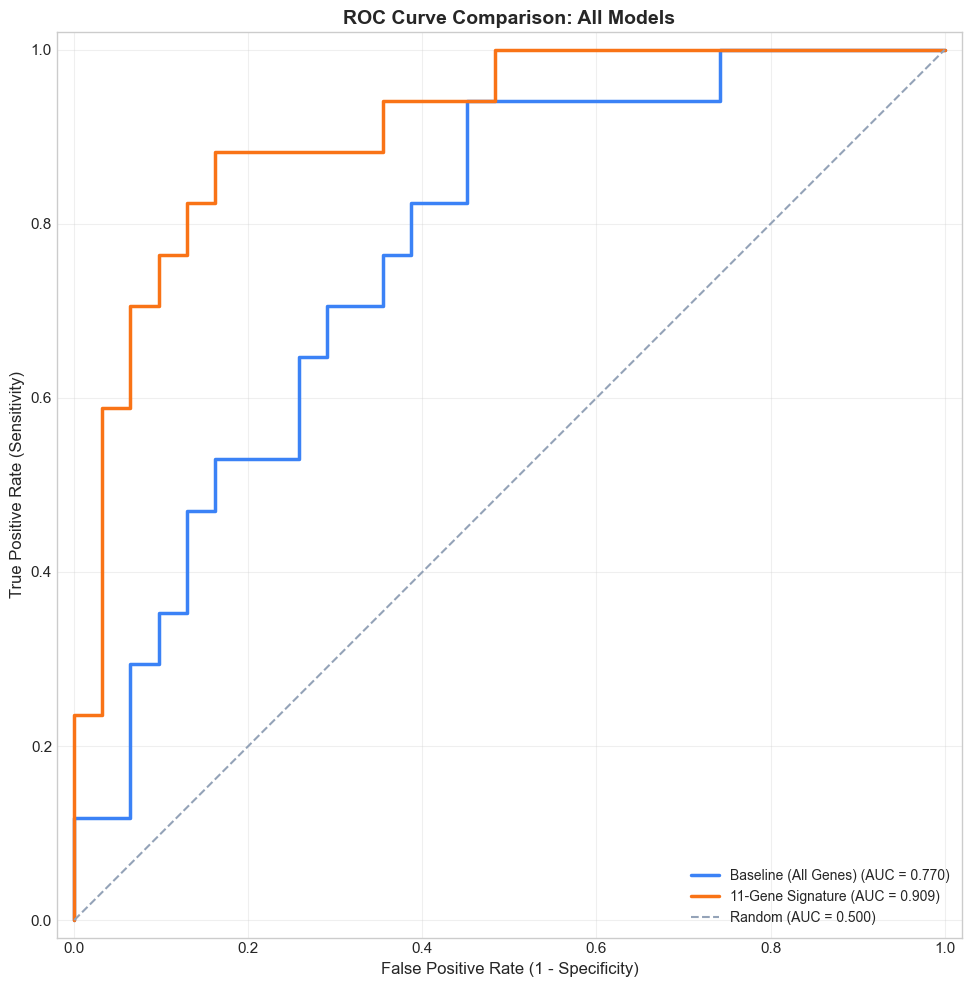

In [20]:
# Run baseline model to get full results for ROC
print("Running baseline model for ROC curve data...")
baseline_full = leave_one_patient_out_cv(adata, verbose=False)

# Prepare results dict for combined ROC
roc_results = {
    "Baseline (All Genes)": {
        "fpr": baseline_full['fpr'],
        "tpr": baseline_full['tpr'],
        "auc": baseline_full['auc'],
    },
    "11-Gene Signature": {
        "fpr": signature_results['fpr'],
        "tpr": signature_results['tpr'],
        "auc": signature_results['auc'],
    },
}

# Plot combined ROC
fig = plot_combined_roc_curves(
    roc_results,
    save_path=project_root / "results" / "figures" / "combined_roc_comparison.png",
    figsize=(10, 10)
)
plt.show()


## 7. Summary and Conclusions


In [21]:
print("="*70)
print("PHASE 5: 11-GENE SIGNATURE ANALYSIS - SUMMARY")
print("="*70)

print("\n1. SIGNATURE GENE PRESENCE")
print("-"*50)
print(f"   Genes found: {presence_info['n_present']}/{presence_info['n_total']}")
if presence_info['genes_missing']:
    print(f"   Missing: {', '.join(presence_info['genes_missing'])}")
else:
    print("   All 11 signature genes are present in our dataset!")

print("\n2. SIGNATURE GENE IMPORTANCE RANKING")
print("-"*50)
if ranks_df is not None:
    n_top_50 = int(ranks_df['in_top_50'].sum())
    n_top_100 = int(ranks_df['in_top_100'].sum())
    avg_rank = ranks_df['rank'].mean()
    print(f"   Signature genes in our top 50:  {n_top_50}/11")
    print(f"   Signature genes in our top 100: {n_top_100}/11")
    print(f"   Average importance rank: {avg_rank:.1f}")
    
    # Top 3 signature genes by our ranking
    top3 = ranks_df.head(3)['gene'].tolist()
    print(f"   Our top 3 signature genes: {', '.join(top3)}")

print("\n3. MODEL PERFORMANCE COMPARISON")
print("-"*50)
print(f"   {'Model':<30} {'Our AUC':>10} {'Paper AUC':>12}")
print(f"   {'-'*54}")
print(f"   {'Baseline (All Genes)':<30} {baseline_auc:>10.4f} {'0.84':>12}")
print(f"   {'Feature Selected':<30} {feature_sel_auc:>10.4f} {'0.89':>12}")
print(f"   {'11-Gene Signature':<30} {signature_auc:>10.4f} {'~0.85':>12}")

print("\n4. KEY FINDINGS")
print("-"*50)

# Determine findings
if signature_auc > 0.7:
    print("   ✓ The 11-gene signature achieves reasonable predictive performance")
else:
    print("   ⚠ The 11-gene signature shows limited predictive performance")

if ranks_df is not None and n_top_50 >= 5:
    print("   ✓ Good overlap between our top genes and the signature")
elif ranks_df is not None:
    print("   ⚠ Partial overlap between our top genes and the signature")

if signature_auc < baseline_auc:
    print(f"   → Using 11 genes has a {(1-signature_auc/baseline_auc)*100:.1f}% AUC drop vs. all genes")
else:
    print(f"   → 11-gene model performs comparably or better than full model")

print("\n" + "="*70)
print("PHASE 5 COMPLETE")
print("="*70)


PHASE 5: 11-GENE SIGNATURE ANALYSIS - SUMMARY

1. SIGNATURE GENE PRESENCE
--------------------------------------------------
   Genes found: 11/11
   All 11 signature genes are present in our dataset!

2. SIGNATURE GENE IMPORTANCE RANKING
--------------------------------------------------
   Signature genes in our top 50:  10/11
   Signature genes in our top 100: 10/11
   Average importance rank: 25.2
   Our top 3 signature genes: GAPDH, IFI6, STAT1

3. MODEL PERFORMANCE COMPARISON
--------------------------------------------------
   Model                             Our AUC    Paper AUC
   ------------------------------------------------------
   Baseline (All Genes)               0.7704         0.84
   Feature Selected                   0.7723         0.89
   11-Gene Signature                  0.9089        ~0.85

4. KEY FINDINGS
--------------------------------------------------
   ✓ The 11-gene signature achieves reasonable predictive performance
   ✓ Good overlap between our top 

## Output Files Generated

This notebook generates the following output files:

### Tables (`results/tables/`)
- `signature_gene_ranks.csv` - Ranking of 11 signature genes by our importance analysis
- `final_comparison.csv` - Comparison of all model AUCs vs paper

### Figures (`results/figures/`)
- `signature_genes_expression.png` - Violin plots of signature gene expression by response
- `signature_importance_comparison.png` - Top 50 features with signature genes highlighted
- `signature_roc.png` - ROC curve for 11-gene model
- `model_auc_comparison.png` - Bar plot comparing all model AUCs
- `combined_roc_comparison.png` - Overlay of ROC curves for all models


In [22]:
# List generated files
print("Generated Output Files:")
print("="*60)

output_files = [
    "results/tables/signature_gene_ranks.csv",
    "results/tables/final_comparison.csv",
    "results/figures/signature_genes_expression.png",
    "results/figures/signature_importance_comparison.png",
    "results/figures/signature_roc.png",
    "results/figures/model_auc_comparison.png",
    "results/figures/combined_roc_comparison.png",
]

for f in output_files:
    path = project_root / f
    exists = "✓" if path.exists() else "✗"
    print(f"  {exists} {f}")


Generated Output Files:
  ✓ results/tables/signature_gene_ranks.csv
  ✓ results/tables/final_comparison.csv
  ✓ results/figures/signature_genes_expression.png
  ✓ results/figures/signature_importance_comparison.png
  ✓ results/figures/signature_roc.png
  ✓ results/figures/model_auc_comparison.png
  ✓ results/figures/combined_roc_comparison.png
